In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as scopt

Методы оптимизации высокого порядка
===================================

Метод Ньютона
-----------------------
Реализуем метод Ньютона:

In [45]:
def Newton(f, grad_f, hess_f, x_0, alpha=1, accuracy=1e-6, max_iter=100):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    
    # Saving path to analize
    path = [x]
                     
    while True:
        # Making step
        x = x - alpha * np.linalg.pinv(hess_f(x)) @ grad_f(x)
        
        iter_count += 1
        
        # Saving path
        path.append(x)
        
        # If the required accuracy or max iterations is achieved then stop
        if np.linalg.norm(grad_f(x)) < accuracy or iter_count >= max_iter:
            break
    
    return {"x": x, "iterations": iter_count, "path": path}

Проверим корректность реализации на простой квадратичной функции
$$f(x, y) = x^2 + 2y^2 + xy - 7x - 7y.$$
Нетрудно посчитать, что $(3, 1)$ --- её минимум.

In [46]:
def f(a):
    x = a[0]
    y = a[1]
    return x ** 2 + 2 * y ** 2 + x * y - 7 * x - 7 * y

def grad_f(a):
    x = a[0]
    y = a[1]
    return np.array([2 * x + y - 7, 4 * y + x - 7])

def hess_f(a):
    return np.array([[2, 1], [1, 4]])

res = Newton(f, grad_f, hess_f, [0, 0])
print("Argmin:", res["x"], "\nMin:", f(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [3. 1.] 
Min: -13.999999999999998 
Iterations:  1


Все верно. На квадратичной фукнции, как и ожидалось, метод Ньютона пришел в точку минимума за один шаг.

Рассмотрим теперь функцию Розенброка:
$$rosen(x, y) = (1 - x)^2 + 100(y - x^2)^2.$$
Её многомерное обобщение:
$$rosen(x) = \sum_{i = 1}^{n - 1} \left(\left(1 - x_i^2\right)^2 + 100\left(x_{i + 1} - x_i^2\right)^2 \right).$$
Её глобальный минимум $rosen(x_{min}) = 0$ в точке $x_{min} = (1, \dots, 1)$.

In [4]:
def rosen(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2)**2 + (1-x[:-1])**2)

def rosen_grad(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

(100, 100)


/tmp/ipykernel_8949/2679046831.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


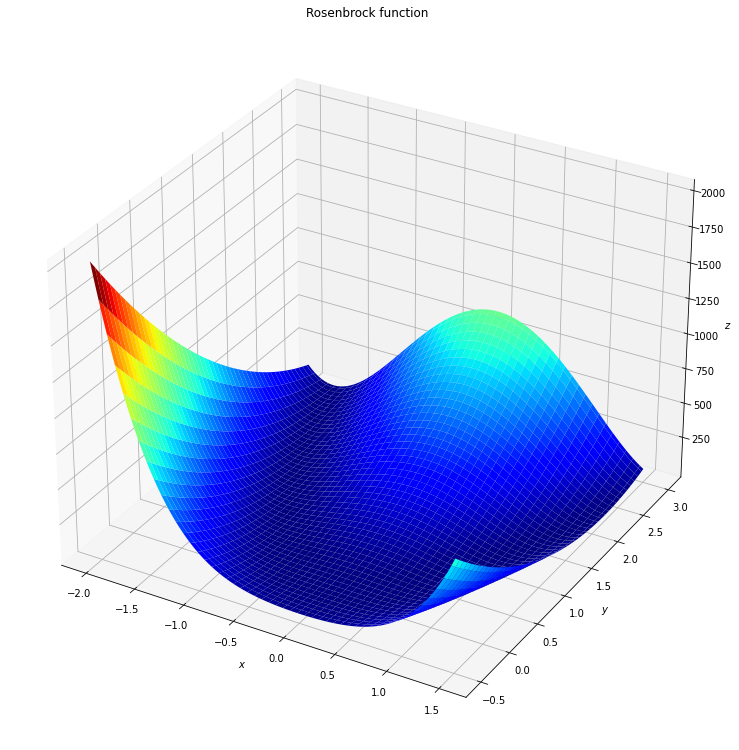

In [5]:
X = np.linspace(-2, 1.5, 100)
Y = np.linspace(-0.5, 3, 100)
x, y = np.meshgrid(X, Y)
print(rosen(np.array([x, y])).shape)

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.plot_surface(x, y, rosen(np.array([x, y])), cmap='jet')
ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
ax.set_title('Rosenbrock function')
plt.show()

Посмотрим как на ней ведет себя метод Ньютона.

In [47]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = Newton(rosen, rosen_grad, rosen_hess, x0)
print("Argmin:", res["x"], "\nMin:", rosen(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [1.         1.         1.         0.99999999 0.99999999] 
Min: 4.3689477573317777e-17 
Iterations:  19


Сравним метод Ньютона с методами более низкого порядка. Метод первого порядка --- градиентный спуск, нулевого --- метод Нелдера-Мида.

In [6]:
def GradDec(f, grad_f, x_0, alpha=0.01, accuracy=1e-3, max_iter=1000):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    
    # Saving path to analize
    path = [x]
                     
    while True:
        # Making step
        x = x - alpha * grad_f(x)
        
        iter_count += 1
        
        # Saving path
        path.append(x)
        
        # If the required accuracy or max iterations is achieved then stop
        if np.linalg.norm(grad_f(x)) < accuracy or iter_count >= max_iter:
            break
    
    return {"x": x, "iterations": iter_count, "path": path}


def NelderMead(func, simplex, alpha=1, beta=0.5, gamma=2, accuracy=0.0001):
    iter_count = 0
    
    # Make a local copy of simplex
    simplex = np.copy(simplex)
    
    # Saving path as mean of simplex
    path = []
    
    n = simplex.shape[1]

    while np.all(np.var(simplex, axis=0) > accuracy):
        path.append(simplex.mean(axis=0))
        iter_count += 1
        
        # Ordering
        func_on_simplex = np.zeros(n + 1)

        for i, x in enumerate(simplex):
            func_on_simplex[i] = func(x)

        index_ordered = np.argsort(func_on_simplex)
        simplex_ordered = simplex[index_ordered]

        # Centroid calculation
        centroid = np.sum(simplex_ordered[:n], axis=0) / n

        # Reflection
        x_r = centroid + alpha * (centroid - simplex_ordered[n])

        if func(x_r) < func(simplex_ordered[0]):
            # Expansion
            x_e = centroid + gamma * (x_r - centroid)
            if func(x_e) < func(x_r):
                simplex[index_ordered[n]] = x_e
            else:
                simplex[index_ordered[n]] = x_r
            continue
        elif func(x_r) < func(simplex_ordered[n - 1]):
            simplex[index_ordered[n]] = x_r
            continue
        else:
            # Contraction
            x_c = centroid + beta * (simplex_ordered[n] - centroid)
            if func(x_c) < func(simplex_ordered[n]):
                simplex[index_ordered[n]] = x_c
            else:
                for i, x_i in enumerate(simplex_ordered[1:]):
                    simplex[i + 1] = simplex_ordered[0] + (x_i - simplex_ordered[0]) / 2
                    
    path.append(simplex.mean(axis=0))
    return {"x": np.mean(simplex, axis=0), "iterations": iter_count, "path": path}

Сравнивать будем на двумерной функции Розенброка, чтобы визуализировать пути методов.

- Newton:
| Argmin: [1. 1.] 
| Min: 1.67632942359465e-30 
| Iterations:  5

- Gradient descent:
| Argmin: [0.95750425 0.91663995] 
| Min: 0.001808931682072844 
| Iterations:  1000

- Nelder-Mead:
| Argmin: [0.99869796 0.99648755] 
| Min: 8.45173821955456e-05 
| Iterations:  36


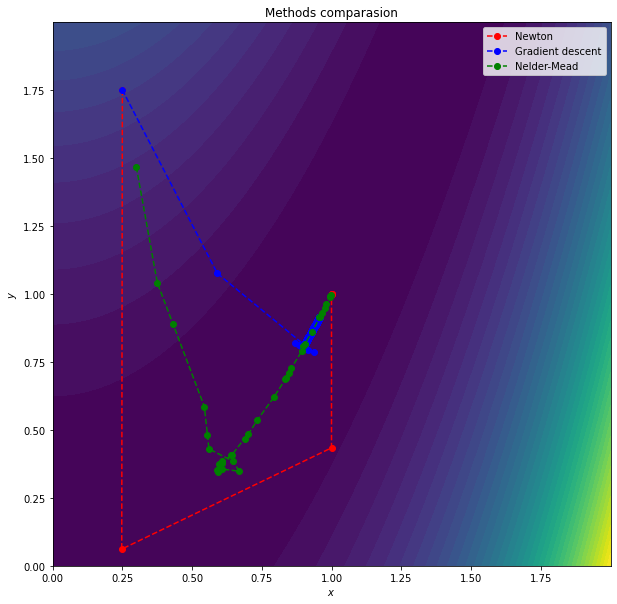

In [48]:
def plot_comparation(X, Y, f, paths_info):
    x, y = np.meshgrid(X, Y)

    plt.figure(figsize=(10, 10))
    plt.contourf(x, y, f(np.array([x,y])), levels=50)
    
    for path_info in paths_info:
        path = path_info["path"]
        plt.plot(path[:, 0].squeeze(), path[:, 1].squeeze(), path_info["style"], label=path_info["name"])
    
    plt.title("Methods comparasion")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()


x0 = np.array([0.25, 1.75])

res = Newton(rosen, rosen_grad, rosen_hess, x0)
print("- Newton:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info = [{"path": np.array(res["path"]), "name": "Newton", "style": "ro--"}]

res = GradDec(rosen, rosen_grad, x0, alpha=0.002, accuracy=0.01)
print("\n- Gradient descent:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info.append({"path": np.array(res["path"]), "name": "Gradient descent", "style": "bo--"})

simplex = [[0.25, 1.75], [0.15, 1.65], [0.5, 1.]]

res = NelderMead(rosen, simplex)
print("\n- Nelder-Mead:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info.append({"path": np.array(res["path"]), "name": "Nelder-Mead", "style": "go--"})

X = np.arange(0, 2, 1e-3)
plot_comparation(X, X, rosen, paths_info)

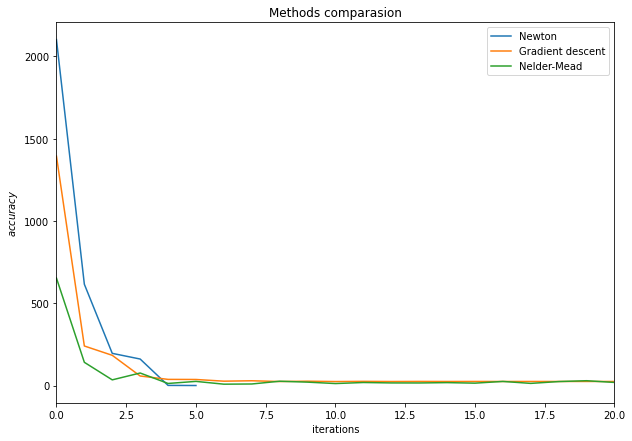

In [8]:
plt.figure(figsize=(10, 7))
for id in range(3):
    plt.plot(np.linalg.norm(rosen_grad(paths_info[id]["path"]), axis=1), label=paths_info[id]["name"])

plt.title("Methods comparasion")
plt.xlabel("iterations")
plt.ylabel("$accuracy$")
plt.xlim(0, 20)
plt.legend()
plt.show()

Заметим, что метод Ньютона всего за пять итераций попал в точную точку минимума, алгоритм Нелдера-Мида достиг заданной точности за $36$ шагов, в то время как градиентный спуск не достиг достаточной точности даже за $1000$ итераций. На данном примере хорошо видно преимущество метода Ньютона над методами более низкого порядка, при соблюдении необходимых и достаточных условий его сходимости (функция дважды дифференцируема и обратный гессиан положительно определён).

BFGS
--------
Реализуем метод BFGS:

In [9]:
import scipy as sp

def BFGS(f, grad_f, x_0, accuracy=1e-6, max_iter=100):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    x_prev = x
    
    # Take identity matrix as first approximation of hessian
    H = np.eye(x.shape[0])
    I = np.eye(x.shape[0])
    
    # Saving path to analize
    path = [x]
                     
    while np.linalg.norm(grad_f(x)) > accuracy and iter_count < max_iter:
        # Step direction
        step = -np.dot(H, grad_f(x))
        
        # Finding optimal alpha
        alpha = sp.optimize.line_search(f, grad_f, x, step)[0]
        
        # Making step
        x_prev = x
        x = x + alpha * step
        
        iter_count += 1
        
        # Saving path
        path.append(x)
            
        # Updating hessian
        dx = x - x_prev
        dy = grad_f(x) - grad_f(x_prev)
        rho = 1. / np.dot(dy, dx)
        H = np.dot((I - rho * np.outer(dx, dy)), np.dot(H, (I - rho * np.outer(dy, dx)))) + rho * np.outer(dx, dx)
        
    return {"x": x, "iterations": iter_count, "path": path}

Проверим корректность реализации на все той же квадратичной функции:

In [10]:
def f(a):
    x = a[0]
    y = a[1]
    return x ** 2 + 2 * y ** 2 + x * y - 7 * x - 7 * y

def grad_f(a):
    x = a[0]
    y = a[1]
    return np.array([2 * x + y - 7, 4 * y + x - 7])

res = BFGS(f, grad_f, np.array([0, 0]))
print("Argmin:", res["x"], "\nMin:", f(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [3. 1.] 
Min: -14.0 
Iterations:  3


Заметим, что в отличие от метода Ньютона, который сразу попал в искомую точку (так как функция квадратичная), BFGS сошелся за несколько шагов, поскольку здесь мы используем приближенное значение гессиана.

Посмотрим теперь как ведет себя метод на функции Розенброка:

In [11]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = BFGS(rosen, rosen_grad, x0)
print("Argmin:", res["x"], "\nMin:", rosen(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [1.         1.         1.         1.         1.00000001] 
Min: 2.377379794162875e-16 
Iterations:  60


Вспомним, что метод Ньютона сошелся быстрее (за 19 шагов). Проверим, действительно ли BFGS эффективнее Ньютона на достаточно большой задаче:

In [27]:
np.random.seed(0)
# Generate 100-dimensional start point
x0 = np.random.uniform(-2, 2, 100)

In [30]:
%%time
res = Newton(rosen, rosen_grad, rosen_hess, x0, max_iter=10000)
print("Argmin:", res["x"], "\nMin:", rosen(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99999999 0.99999998 0.99999997
 0.99999993 0.99999986 0.99999972 0.9999

In [32]:
%%time
res = BFGS(rosen, rosen_grad, x0, max_iter=10000)
print("Argmin:", res["x"], "\nMin:", rosen(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.] 
Min: 5.82332059809208e-17 
Iterations:  278
CPU times: user 1.52 s, sys: 1.61 s, total: 3.13 s
Wall time: 421 ms


Получили ускорение примерно в десять раз. Посмотрим на пути, проходимые методами в двумерном варианте из разных точек:

Start from  [0.25 1.75]

- Newton:
| Argmin: [1. 1.] 
| Min: 1.67632942359465e-30 
| Iterations:  5

- BFGS:
| Argmin: [1. 1.] 
| Min: 2.4405053943929857e-19 
| Iterations:  18


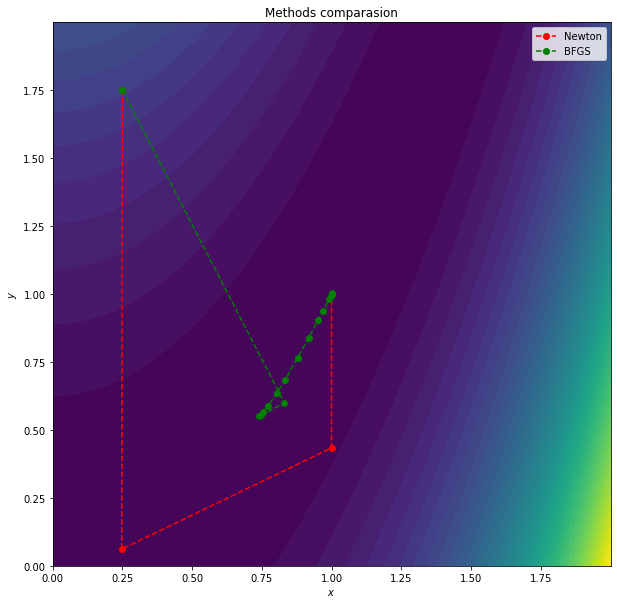

In [15]:
def compare_NB(x0):
    print("Start from ", x0)

    res = Newton(rosen, rosen_grad, rosen_hess, x0)
    print("\n- Newton:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
    paths_info = [{"path": np.array(res["path"]), "name": "Newton", "style": "ro--"}]

    res = BFGS(rosen, rosen_grad, x0)
    print("\n- BFGS:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
    paths_info.append({"path": np.array(res["path"]), "name": "BFGS", "style": "go--"})

    X = np.arange(0, 2, 1e-3)
    plot_comparation(X, X, rosen, paths_info)

compare_NB(np.array([0.25, 1.75]))

Start from  [1.4  1.75]

- Newton:
| Argmin: [1. 1.] 
| Min: 2.505828050585249e-19 
| Iterations:  5

- BFGS:
| Argmin: [1. 1.] 
| Min: 4.673236388413874e-18 
| Iterations:  15


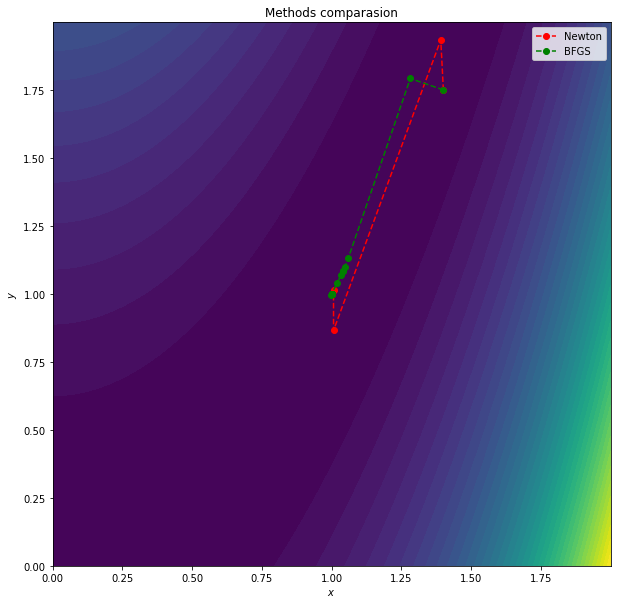

In [16]:
compare_NB(np.array([1.4, 1.75]))

Start from  [0.2 0.2]

- Newton:
| Argmin: [1. 1.] 
| Min: 1.0944201862449094e-18 
| Iterations:  6

- BFGS:
| Argmin: [1.00000001 1.00000003] 
| Min: 3.299444259309292e-16 
| Iterations:  20


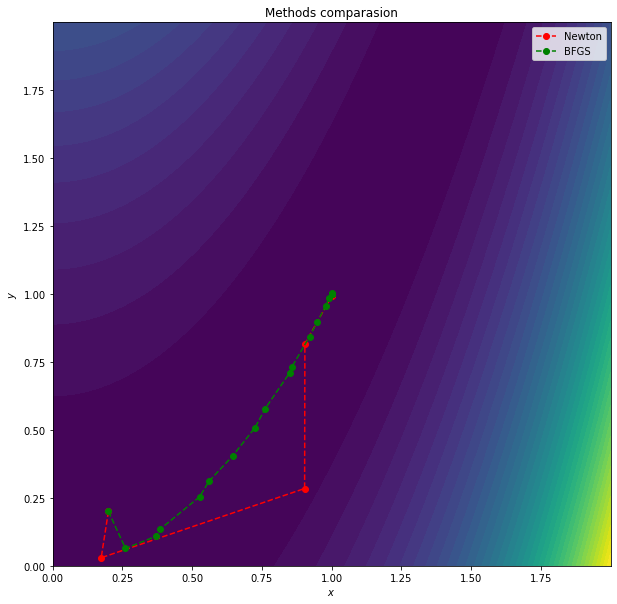

In [17]:
compare_NB(np.array([0.2, 0.2]))

- Newton:
| Argmin: [2.51274332 2.51274332] 
| Min: 52.56368235502447 
| Iterations:  4
- BFGS:
| Argmin: [-0.99495864 -0.99495864] 
| Min: 1.9899181141865832 
| Iterations:  5


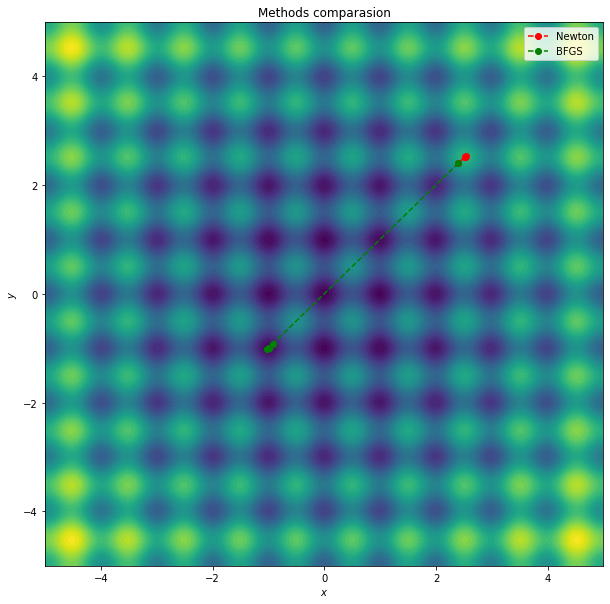

In [18]:
def rastr(a):
    x = a[0]
    y = a[1]
    return 20 + x ** 2 + y ** 2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

def rastr_grad(a):
    x = a[0]
    y = a[1]
    return np.array([2 * x + 20 * np.pi * np.sin(2 * np.pi * x), 2 * y + 20 * np.pi * np.sin(2 * np.pi * y)])
                                        
def rastr_hess(a):
    x = a[0]
    y = a[1]
    return np.array([[2 + 40 * (np.pi ** 2) * np.cos(2 * np.pi * x), 0], [0, 2 + 40 * (np.pi ** 2) * np.cos(2 * np.pi * y)]])
                                        
x0 = np.array([2.4, 2.4])

res = Newton(rastr, rastr_grad, rastr_hess, x0)
print("- Newton:\n| Argmin:", res["x"], "\n| Min:", rastr(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info = [{"path": np.array(res["path"]), "name": "Newton", "style": "ro--"}]

res = BFGS(rastr, rastr_grad, x0)
print("- BFGS:\n| Argmin:", res["x"], "\n| Min:", rastr(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info.append({"path": np.array(res["path"]), "name": "BFGS", "style": "go--"})

X = np.arange(-5, 5, 1e-2)
plot_comparation(X, X, rastr, paths_info)